## Evaluating Faithfulness

This notebook takes an in-depth look at the csv files generated in `MetaLogic-Image-Eval.ipynb`. Taking the original text perturbation prompt pairs and the VQA results, it analyzes faithfulness and stability scores looking across the 20 pertubation categories, the 5 logical law categories, and the 4 semantic dimensions.

These results are plotted into charts to visualize our metrics and the last section shows a couple qualitative examples from the worst-performing categories.

Folder setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root_dir = "/content/drive/MyDrive/Projects/Robustness-Final"

In [3]:
import pandas as pd

#### Import raw results

The csv file has a "category_id" column which identifies one of the 20 categories, we can group the results by this and grab the questions and get the average per category and looking at the "is_correct" to get faithfulness

In [4]:
faith_scores = pd.read_csv(root_dir + "/vqa_raw_results.csv")
faith_scores.head()

,pair_id,logical_law,category_id,semantic_dimension,image_variant,image_path,question,expected_answer,predicted_answer_raw,predicted_answer_norm,is_correct
0,comm_conj_001,Commutative,1,Conjunctive,A,/content/drive/MyDrive/Trustworthy-AI-Final/Im...,Is there a red cat in the image?,yes,yes,yes,1
1,comm_conj_001,Commutative,1,Conjunctive,A,/content/drive/MyDrive/Trustworthy-AI-Final/Im...,Is there a yellow apple in the image?,yes,yes,yes,1
2,comm_conj_001,Commutative,1,Conjunctive,A,/content/drive/MyDrive/Trustworthy-AI-Final/Im...,Are the objects placed on a wooden table?,yes,yes,yes,1
3,comm_conj_001,Commutative,1,Conjunctive,A,/content/drive/MyDrive/Trustworthy-AI-Final/Im...,Is the apple yellow in color?,yes,yes,yes,1
4,comm_conj_001,Commutative,1,Conjunctive,A,/content/drive/MyDrive/Trustworthy-AI-Final/Im...,Is the cat red in color?,yes,yes,yes,1


In [5]:
Prompt_Pairs = pd.read_csv(root_dir + "/prompts_metalogic.csv")
Prompt_Pairs.head()

,pair_id,category_id,logical_law,semantic_dimension,prompt_A,prompt_B
0,comm_conj_001,1,Commutative,Conjunctive,a red cat and a yellow apple on a wooden table,a yellow apple and a red cat on a wooden table
1,comm_conj_002,1,Commutative,Conjunctive,a blue dog and a yellow cat on a dark metal floor,a yellow cat and a blue dog on a dark metal floor
2,comm_conj_003,1,Commutative,Conjunctive,a red banana and a blue cat on a wooden table,a blue cat and a red banana on a wooden table
3,comm_conj_004,1,Commutative,Conjunctive,a blue dog and a yellow banana on a wooden table,a yellow banana and a blue dog on a wooden table
4,comm_conj_005,1,Commutative,Conjunctive,a blue banana and a red dog on a dark metal floor,a red dog and a blue banana on a dark metal floor


#### Calculate Faithfulness for Image Pairs

In [6]:
# Faithfulness per image (per prompt)
faith_per_image = (
    faith_scores
      .groupby(["pair_id", "image_variant"])
      .agg(
          vqa_accuracy=("is_correct", "mean"),
          num_questions=("is_correct", "size"),
      )
      .reset_index()
)

faith_per_image.head()

# Put A and B in same row for each pair
faith_pivot = faith_per_image.pivot(
    index="pair_id",
    columns="image_variant",
    values="vqa_accuracy",
).reset_index()

faith_pivot = faith_pivot.rename(columns={"A": "faith_A", "B": "faith_B"})

# Merge metadata from Prompt_Pairs
meta_cols = ["pair_id", "logical_law", "category_id", "semantic_dimension"]
meta_df = Prompt_Pairs[meta_cols].drop_duplicates()

vqa_pair_metrics = faith_pivot.merge(meta_df, on="pair_id", how="left")

# TIFA-lite style scores
vqa_pair_metrics["faith_mean"] = 0.5 * (vqa_pair_metrics["faith_A"] + vqa_pair_metrics["faith_B"])
vqa_pair_metrics["faith_diff"] = (vqa_pair_metrics["faith_A"] - vqa_pair_metrics["faith_B"]).abs()
vqa_pair_metrics["faith_stability"] = 1 - (vqa_pair_metrics["faith_A"] - vqa_pair_metrics["faith_B"]).abs()

vqa_pair_metrics.head()
vqa_pair_metrics.to_csv(root_dir + "/vqa_pair_metrics.csv")

$VQAStability(p_1, p_2) = 1 - | Faithfulness(p_1, I_{p-1}) - Faithfulness(p_2, I_{p-2})|$


#### Category-level Metrics

In [7]:
category_metrics = (
    vqa_pair_metrics
    .groupby(["category_id", "logical_law", "semantic_dimension"])
      .agg(
          n_pairs      = ("pair_id", "nunique"),
          mean_faith_A = ("faith_A", "mean"),
          mean_faith_B = ("faith_B", "mean"),
          mean_faith   = ("faith_mean", "mean"),
          mean_faith_stability = ("faith_stability", "mean"), # Renamed to faith_stability
      )
      .reset_index()
      .sort_values("mean_faith_stability")
)

category_metrics.head()
category_metrics.to_csv(root_dir + "/category_metrics.csv")

Low faithfulness displays that the model did not do a good job generating the scene

Low faith stability shows that the model is not invariant to the logical rule

In [8]:
category_metrics.sort_values("mean_faith_stability").head(10)

,category_id,logical_law,semantic_dimension,n_pairs,mean_faith_A,mean_faith_B,mean_faith,mean_faith_stability
0,1,Commutative,Conjunctive,5,0.36,0.64,0.50,0.56
19,20,DeMorgan,Attributes,5,0.64,0.52,0.58,0.64
9,10,Distributive,Horizontal,5,0.60,0.32,0.46,0.64
6,7,Associative,Vertical,5,0.32,0.52,0.42,0.64
12,13,Complement,Conjunctive,5,0.56,0.80,0.68,0.68
4,5,Associative,Conjunctive,5,0.56,0.40,0.48,0.68
16,17,DeMorgan,Conjunctive,5,0.32,0.48,0.40,0.68
18,19,DeMorgan,Vertical,5,0.48,0.36,0.42,0.72
15,16,Complement,Attributes,5,0.72,0.64,0.68,0.76
13,14,Complement,Horizontal,5,0.48,0.64,0.56,0.76


In [9]:
category_metrics.sort_values("mean_faith").head(10)

,category_id,logical_law,semantic_dimension,n_pairs,mean_faith_A,mean_faith_B,mean_faith,mean_faith_stability
1,2,Commutative,Horizontal,5,0.36,0.40,0.38,0.80
5,6,Associative,Horizontal,5,0.32,0.44,0.38,0.88
2,3,Commutative,Vertical,5,0.40,0.40,0.40,0.84
16,17,DeMorgan,Conjunctive,5,0.32,0.48,0.40,0.68
10,11,Distributive,Vertical,5,0.32,0.48,0.40,0.84
18,19,DeMorgan,Vertical,5,0.48,0.36,0.42,0.72
6,7,Associative,Vertical,5,0.32,0.52,0.42,0.64
14,15,Complement,Vertical,5,0.40,0.52,0.46,0.80
9,10,Distributive,Horizontal,5,0.60,0.32,0.46,0.64
4,5,Associative,Conjunctive,5,0.56,0.40,0.48,0.68


## Plotted Results

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

#### Mean Faithfulness/Stability per Category

Mean Faithfulness

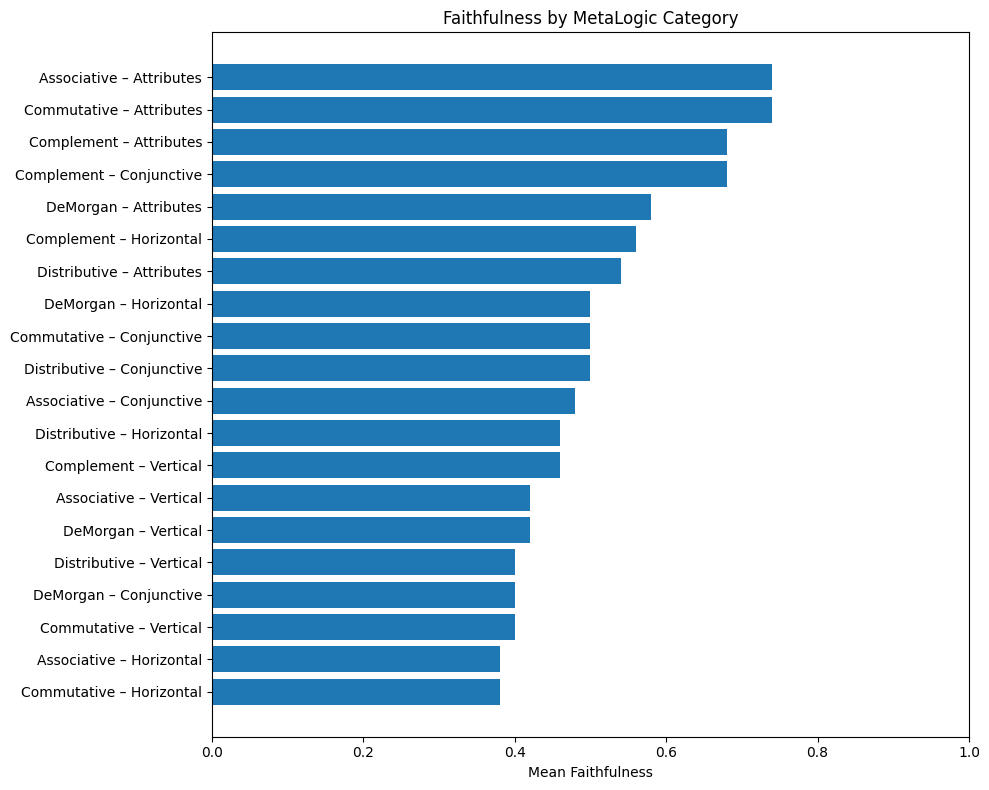

In [11]:
category_metrics["category_label"] = (
    category_metrics["logical_law"] + " – " + category_metrics["semantic_dimension"]
)

# Sort by stability (lowest first so weakest categories are visible)
category_metrics = category_metrics.sort_values("mean_faith", ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(
    category_metrics["category_label"],
    category_metrics["mean_faith"],
)
plt.xlabel("Mean Faithfulness")
plt.title("Faithfulness by MetaLogic Category")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(root_dir + "/category_faithfulness_bar.png")
plt.show()


Mean Stability


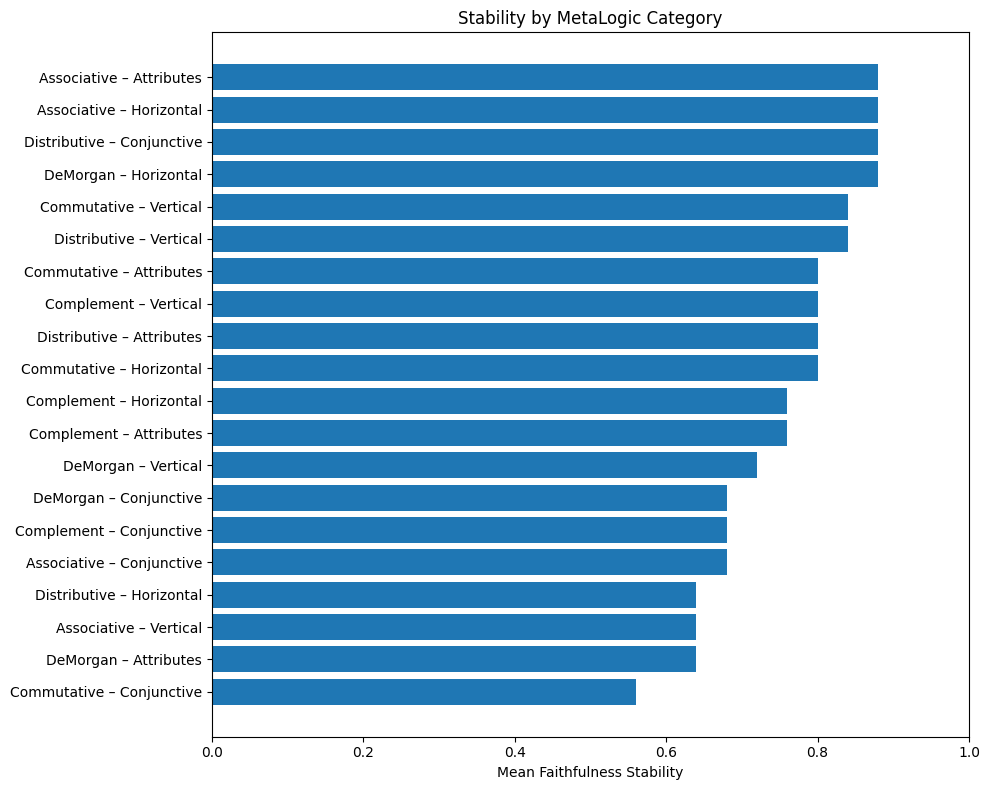

In [12]:
# Sort by stability (lowest first so weakest categories are visible)
category_metrics = category_metrics.sort_values("mean_faith_stability", ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(
    category_metrics["category_label"],
    category_metrics["mean_faith_stability"],
)
plt.xlabel("Mean Faithfulness Stability")
plt.title("Stability by MetaLogic Category")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(root_dir + "/category_stability_bar.png")
plt.show()

#### Mean Faithfulness/Stability per Logical Law

switch out "mean_faith" and "mean_faith_stab" to look at each plotted chart

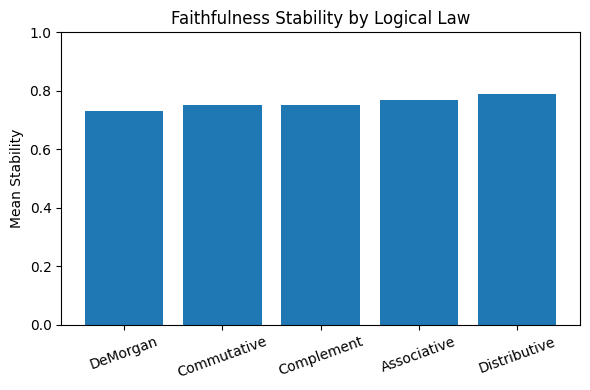

In [13]:
logical_law_summary = (
    vqa_pair_metrics
      .groupby("logical_law")
      .agg(
          mean_faith_stab = ("faith_stability", "mean"),
          mean_faith      = ("faith_mean", "mean"),
          n_pairs         = ("pair_id", "nunique"),
      )
      .reset_index()
      .sort_values("mean_faith_stab", ascending=True)
)

plt.figure(figsize=(6, 4))
plt.bar(
    logical_law_summary["logical_law"],
    logical_law_summary["mean_faith_stab"],
)
plt.ylabel("Mean Stability")
plt.title("Faithfulness Stability by Logical Law")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(root_dir + "/logical_law_stability_bar.png")
plt.show()


#### Mean Faithfulness/Stability per Semantic Dimension

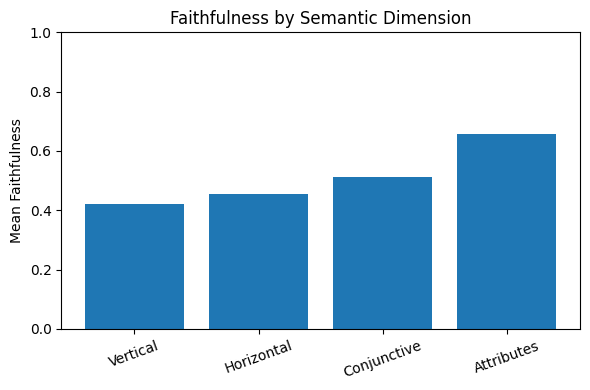

In [14]:
semantic_dim_summary = (
    vqa_pair_metrics
      .groupby("semantic_dimension")
      .agg(
          mean_faith_stab = ("faith_stability", "mean"),
          mean_faith      = ("faith_mean", "mean"),
          n_pairs         = ("pair_id", "nunique"),
      )
      .reset_index()
      .sort_values("mean_faith", ascending=True)
)

plt.figure(figsize=(6, 4))
plt.bar(
    semantic_dim_summary["semantic_dimension"],
    semantic_dim_summary["mean_faith"],
)
plt.ylabel("Mean Faithfulness")
plt.title("Faithfulness by Semantic Dimension")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(root_dir + "/semantic_dim_faithfulness_bar.png")
plt.show()

#### Heatmap of Stability

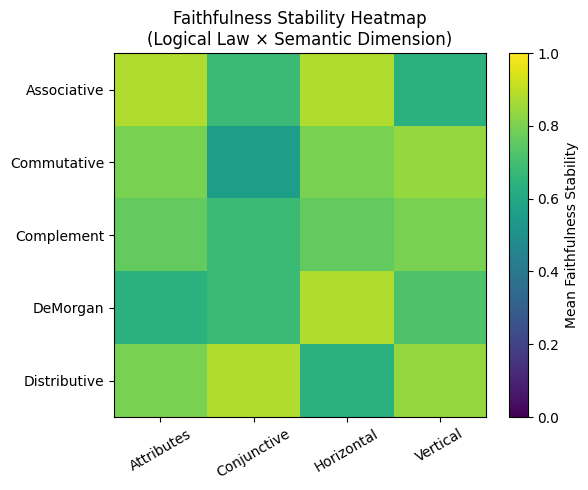

In [15]:
heatmap_df = (
    vqa_pair_metrics
      .groupby(["logical_law", "semantic_dimension"])
      .agg(mean_faith_stab=("faith_stability", "mean"))
      .reset_index()
      .pivot(index="logical_law", columns="semantic_dimension", values="mean_faith_stab")
)

plt.figure(figsize=(6, 5))
plt.imshow(heatmap_df, aspect="auto", vmin=0, vmax=1)
plt.colorbar(label="Mean Faithfulness Stability")

plt.xticks(
    ticks=range(len(heatmap_df.columns)),
    labels=heatmap_df.columns,
    rotation=30,
)
plt.yticks(
    ticks=range(len(heatmap_df.index)),
    labels=heatmap_df.index,
)

plt.title("Faithfulness Stability Heatmap\n(Logical Law × Semantic Dimension)")
plt.tight_layout()
plt.savefig(root_dir + "/heatmap_stability.png")
plt.show()

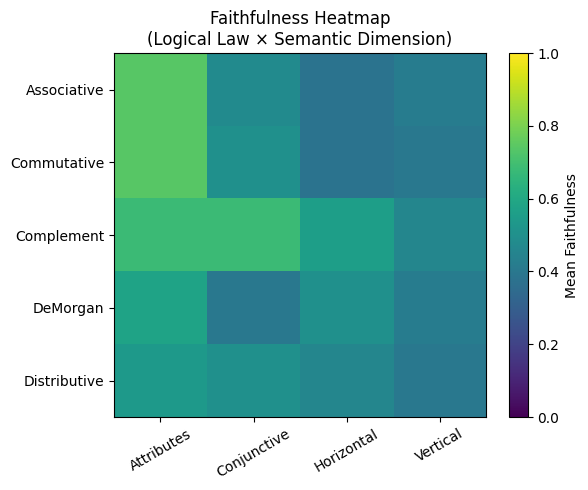

In [16]:
heatmap_df = (
    vqa_pair_metrics
      .groupby(["logical_law", "semantic_dimension"])
      .agg(mean_faith=("faith_mean", "mean"))
      .reset_index()
      .pivot(index="logical_law", columns="semantic_dimension", values="mean_faith")
)

plt.figure(figsize=(6, 5))
plt.imshow(heatmap_df, aspect="auto", vmin=0, vmax=1)
plt.colorbar(label="Mean Faithfulness")

plt.xticks(
    ticks=range(len(heatmap_df.columns)),
    labels=heatmap_df.columns,
    rotation=30,
)
plt.yticks(
    ticks=range(len(heatmap_df.index)),
    labels=heatmap_df.index,
)

plt.title("Faithfulness Heatmap\n(Logical Law × Semantic Dimension)")
plt.tight_layout()
plt.savefig(root_dir + "/heatmap_faithfulness.png")
plt.show()

## Qualitative Examples

Setup

In [17]:
image_folder = root_dir + "/images"

Weakest 3 categories for faithfulness and stability

In [18]:
category_metrics.sort_values("mean_faith").head(3)

,category_id,logical_law,semantic_dimension,n_pairs,mean_faith_A,mean_faith_B,mean_faith,mean_faith_stability,category_label
1,2,Commutative,Horizontal,5,0.36,0.40,0.38,0.80,Commutative – Horizontal
5,6,Associative,Horizontal,5,0.32,0.44,0.38,0.88,Associative – Horizontal
2,3,Commutative,Vertical,5,0.40,0.40,0.40,0.84,Commutative – Vertical


In [19]:
category_metrics.sort_values("mean_faith_stability").head(3)

,category_id,logical_law,semantic_dimension,n_pairs,mean_faith_A,mean_faith_B,mean_faith,mean_faith_stability,category_label
0,1,Commutative,Conjunctive,5,0.36,0.64,0.50,0.56,Commutative – Conjunctive
19,20,DeMorgan,Attributes,5,0.64,0.52,0.58,0.64,DeMorgan – Attributes
6,7,Associative,Vertical,5,0.32,0.52,0.42,0.64,Associative – Vertical


### Weak Faithfulness Examples - Commutative Horizontal

#### Commutative Horizontal Prompt Pair 1, Prompt A
Both vertical and horizontal semantic dimensions had poor mean faithfulness scores across all 5 logical laws. Furthermore, the generated images below showcase that the Commutative Horizontal category also struggled with object presence, not including all necessary objects in the image, as well as improper attribute binding, only vaguely getting colors right.


Prompt A: "a green cat to the left of a red banana on a plain white surface"

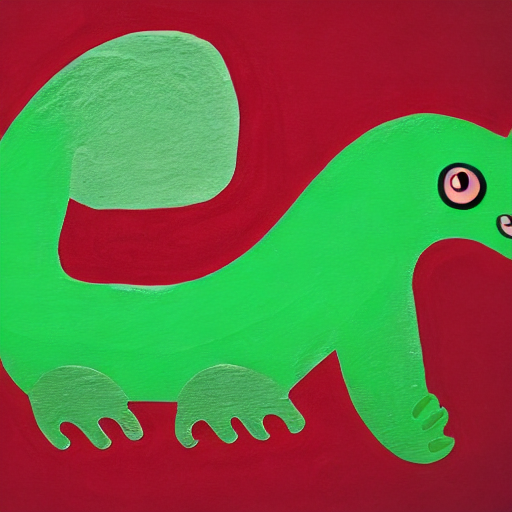

Prompt B: "a red banana to the right of a green cat on a plain white surface"

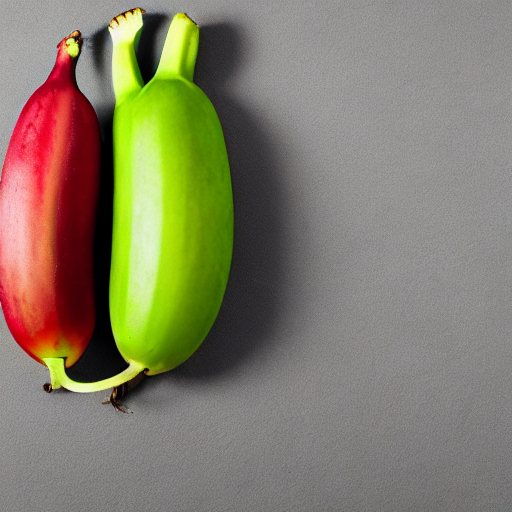

### Weak Stability Examples - Commutative Conjunctive

In contrast, the commutative conjunctive category produced slightly more faithful images (doesn't need spatial reasoning), and while we can see that the images clearly contained the proper objects, the attribute binding in the second image is clearly off compared to the first. This demonstrates weak stability, as the semantically same, but perturbed prompts generate inconsistent images.

#### Commutative Conjunctive Prompt Pair 1
Prompt A: "a red cat and a yellow apple on a wooden table"

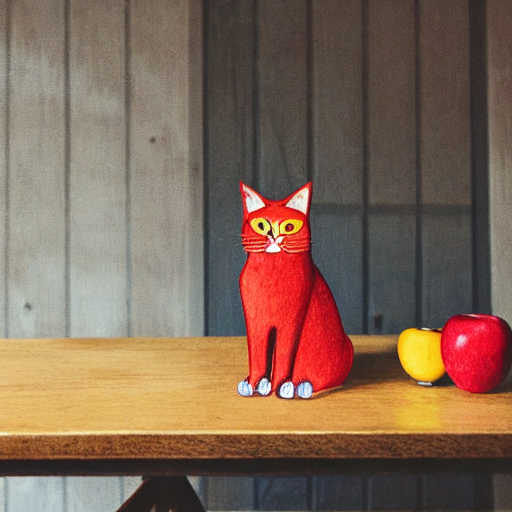

Prompt B: "a yellow apple and a red cat on a wooden table"

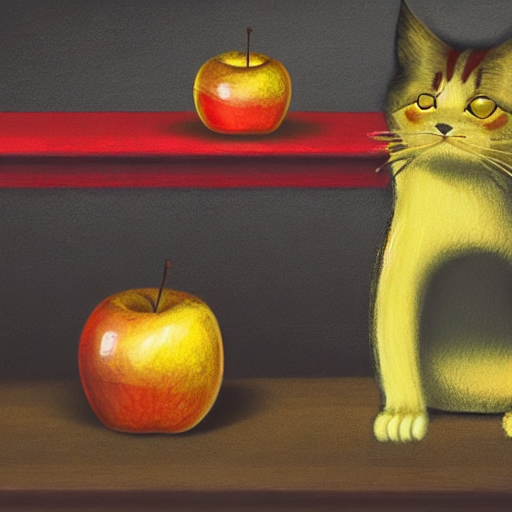